<a href="https://colab.research.google.com/github/regaby/tp_ml/blob/main/ML_docinf_Rivero.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
# Autora: Ing. Gabriela Rivero (regaby@gmail.com)
# Agosto 2021

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from datetime import timedelta
from IPython.display import display
from sklearn.manifold import TSNE

from time import time
from sklearn import metrics
from sklearn.pipeline import make_pipeline


In [17]:
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)



In [18]:
!wget -P / https://github.com/regaby/tp_ml/raw/main/data_ba.zip

--2021-08-30 18:12:58--  https://github.com/regaby/tp_ml/raw/main/data_ba.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/regaby/tp_ml/main/data_ba.zip [following]
--2021-08-30 18:12:58--  https://raw.githubusercontent.com/regaby/tp_ml/main/data_ba.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21091822 (20M) [application/zip]
Saving to: ‘data_ba.zip.1’

ata_ba.zip.1        100%[===================>]  20.11M   129MB/s    in 0.2s    

2021-08-30 18:12:58 (129 MB/s) - ‘data_ba.zip.1’ saved [21091822/21091822]



In [19]:
!unzip data_ba.zip

Archive:  data_ba.zip
replace data_ba.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: data_ba.csv             


In [20]:

## data preparation

#__________________
# read the datafile
df_initial = pd.read_csv('data_ba.csv',encoding="utf-8")


In [21]:

print('\n <<< Cantidad de ejemplos y características >>>')
print(df_initial.shape)



 <<< Cantidad de ejemplos y características >>>
(877378, 10)


In [22]:

print('\n <<< Primeras filas del dataset >>>')
print(df_initial.head(5))
print (display(df_initial[:5]))




 <<< Primeras filas del dataset >>>
   InvoiceNo  StockCode  ... CustomerID     City
0          7      12160  ...        120  Neuquen
1          7      12160  ...        120  Neuquen
2          7      12160  ...        120  Neuquen
3         13       7020  ...       7190  Neuquen
4         18        177  ...       7190  Neuquen

[5 rows x 10 columns]


,InvoiceNo,StockCode,Description,Category,ParentCategory,Quantity,InvoiceDate,UnitPrice,CustomerID,City
0,7,12160,"ALFOMBRA BA¥O SESAMO 0,40",Blanqueria.Com,Cubrecamas Una Plaza,2.0,2005-08-18,16.53,120,Neuquen
1,7,12160,ALFOMBRA P/BAÐO USA CANNO,Blanqueria.Com,Cubrecamas Una Plaza,1.0,2005-08-18,11.16,120,Neuquen
2,7,12160,ALFOMBRA P/BAÐO USA CANNO,Blanqueria.Com,Cubrecamas Una Plaza,1.0,2005-08-18,11.16,120,Neuquen
3,13,7020,SIMPLEX COLCHON 0.80 x 18 x 1.90,Linea Simplex,Colchones Vazquez,1.0,2005-11-17,140.50,7190,Neuquen
4,18,177,TRISET ARTEX PERCAL 180 2,Coteminas,Sabanas 2 Plazas - Queen,1.0,2005-11-17,69.33,7190,Neuquen


None


In [23]:


print('\n <<< Información del dataset >>>')
print(df_initial.info())




 <<< Información del dataset >>>
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 877378 entries, 0 to 877377
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   InvoiceNo       877378 non-null  int64  
 1   StockCode       877378 non-null  int64  
 2   Description     877361 non-null  object 
 3   Category        877378 non-null  object 
 4   ParentCategory  877365 non-null  object 
 5   Quantity        877378 non-null  float64
 6   InvoiceDate     877350 non-null  object 
 7   UnitPrice       877378 non-null  float64
 8   CustomerID      877378 non-null  int64  
 9   City            721389 non-null  object 
dtypes: float64(2), int64(3), object(5)
memory usage: 66.9+ MB
None


In [24]:


print('\n <<< Información estadística del dataset >>>')
print(df_initial.describe())



 <<< Información estadística del dataset >>>
           InvoiceNo      StockCode  ...      UnitPrice     CustomerID
count  877378.000000  877378.000000  ...  877378.000000  877378.000000
mean   221452.806663   15302.544501  ...    1808.423981   80957.662880
std    125640.236239    9273.020636  ...    5187.756229   62520.448473
min         3.000000      80.000000  ...       0.000000     115.000000
25%    111776.000000    8876.000000  ...     115.350000   27666.000000
50%    225116.500000   12998.000000  ...     350.620000   69398.000000
75%    331915.750000   17508.000000  ...    1218.650000  123433.000000
max    431737.000000   41020.000000  ...  249697.890000  249205.000000

[8 rows x 5 columns]


In [25]:

df_initial['InvoiceDate'] = pd.to_datetime(df_initial['InvoiceDate'])

print('Transacciones desde {} hasta {}'.format(df_initial['InvoiceDate'].min(),
                                    df_initial['InvoiceDate'].max()))



Transacciones desde 2005-08-11 00:00:00 hasta 2021-06-17 00:00:00


In [26]:

# --Agrupando datos por customerID--

# Creando TotalSum
df_initial['TotalSum'] = df_initial['Quantity'] * df_initial['UnitPrice']


In [27]:

# Creando snapshot date
snapshot_date = df_initial['InvoiceDate'].max() + timedelta(days=1)
print('snapshot_date',snapshot_date)


snapshot_date 2021-06-18 00:00:00


In [28]:

# Agrupando por CustomerID
data_process = df_initial.groupby(['CustomerID']).agg({
        'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
        'InvoiceNo': 'count',
        'TotalSum': 'sum'})

# Renombrando las columnas
data_process.rename(columns={'InvoiceDate': 'Recency',
                         'InvoiceNo': 'Frequency',
                         'TotalSum': 'MonetaryValue'}, inplace=True)


142,481 rows; 3 columns
montos desde 0.0 hasta 14857365.299000429

Distribución RFM - sin normalizar


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

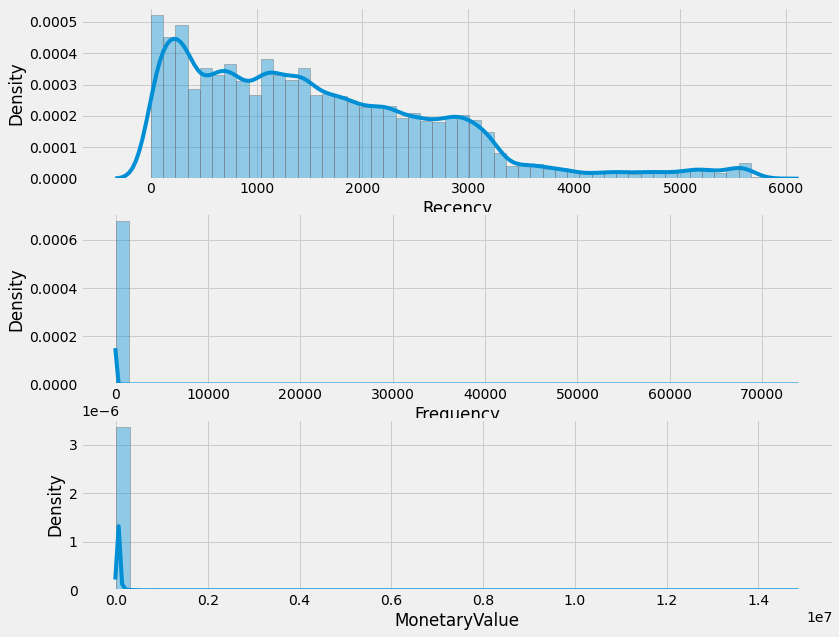

In [30]:

# Print top 5 rows and shape of dataframe
# print(data_process.head())
print('{:,} rows; {:,} columns'
      .format(data_process.shape[0], data_process.shape[1]))

print('montos desde {} hasta {}'.format(data_process['MonetaryValue'].min(),
                                    data_process['MonetaryValue'].max()))

def plot_rfm(dataset):
    # Plot RFM distributions
    plt.figure(figsize=(12,10))
    # Plot distribution of R
    plt.subplot(3, 1, 1); sns.distplot(dataset['Recency'])
    # Plot distribution of F
    plt.subplot(3, 1, 2); sns.distplot(dataset['Frequency'])
    # Plot distribution of M
    plt.subplot(3, 1, 3); sns.distplot(dataset['MonetaryValue'])
    # Show the plot
    plt.show()

print ("\nDistribución RFM - sin normalizar")
plot_rfm(data_process)



Normalizo el dataset

Distribución RFM - Normalizada


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

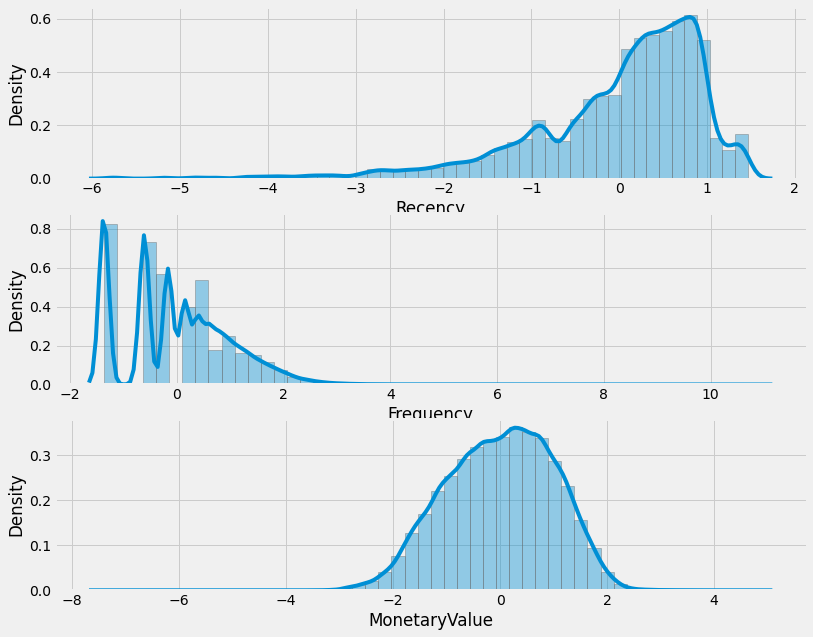

In [32]:
print ('Normalizo el dataset')
# define function for the values below 0
def neg_to_zero(x):
    if x <= 0:
        return 1
    else:
        return x
# apply the function to Recency and MonetaryValue column
data_process['Recency'] = [neg_to_zero(x) for x in data_process['Recency']]
data_process['MonetaryValue'] = [neg_to_zero(x) for x in data_process['MonetaryValue']]
# unskew the data
rfm_log = data_process[['Recency', 'Frequency', 'MonetaryValue']].apply(np.log, axis = 1).round(3)

# scale the data
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)
# transform into a dataframe
rfm_scaled = pd.DataFrame(rfm_scaled, index = data_process.index, columns = rfm_log.columns)

## Dataset sin normalizar
data_process_array = np.nan_to_num(data_process)
## Dataset normalizado
print ("\nDistribución RFM - Normalizada")
plot_rfm(rfm_scaled)
rfm_scaled = np.nan_to_num(rfm_scaled)

In [33]:
def get_elbow(dataset):
    # the Elbow method
    wcss = {}
    for k in range(1, 11):
        kmeans = KMeans(n_clusters= k, init= 'k-means++', max_iter= 300)
        kmeans.fit(dataset)
        wcss[k] = kmeans.inertia_
    # plot the WCSS values
    sns.pointplot(x = list(wcss.keys()), y = list(wcss.values()))
    plt.xlabel('K Numbers')
    plt.ylabel('WCSS')
    plt.show()

# elbow sin normalizar
print ('\nElbow con dataset sin normalizar')
# get_elbow(data_process_array)
# elbow normalizado
print ('\nElbow con dataset normalizado')
# get_elbow(rfm_scaled)


Elbow con dataset sin normalizar

Elbow con dataset normalizado


In [ ]:
############################################################## metricas

def bench_k_means(#kmeans,
    init, data, test_label, clusters_number, original_df_rfm):
    """Benchmark to evaluate the KMeans initialization methods.

    Parameters
    ----------
    kmeans : KMeans instance
        A :class:`~sklearn.cluster.KMeans` instance with the initialization
        already set.
    name : str
        Name given to the strategy. It will be used to show the results in a
        table.
    data : ndarray of shape (n_samples, n_features)
        The data to cluster.
    labels : ndarray of shape (n_samples,)
        The labels used to compute the clustering metrics which requires some
        supervision.
    """
    t0 = time()

    clus = KMeans(n_clusters= clusters_number, init= init, max_iter= 300)

    clus.fit(data)
    labels = clus.labels_
    # print ('clus.labels_',np.unique(clus.labels_))

    estimator = make_pipeline(StandardScaler(), clus).fit(data)
    fit_time = time() - t0
    results = [test_label, fit_time, estimator[-1].inertia_]

    # Define the metrics which require only the true labels and estimator
    # labels
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
        metrics.adjusted_mutual_info_score,
    ]
    results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]

    # The silhouette score requires the full dataset
    results += [
        metrics.silhouette_score(data, estimator[-1].labels_,
                                 metric="euclidean", sample_size=300,)
    ]

    # Show the results
    formatter_result = ("{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}"
                        "\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}")
    print(formatter_result.format(*results))

    # Create a cluster label column in original dataset
    df_new = original_df_rfm.assign(Cluster = labels)

    # Initialise TSNE
    model = TSNE(random_state=1)
    df_new_array = np.nan_to_num(df_new)
    transformed = model.fit_transform(df_new_array)

    # Plot t-SNE
    plt.title('{} Clusters- {}'.format(clusters_number, test_label))
    sns.scatterplot(x=transformed[:,0], y=transformed[:,1], hue=labels, style=labels, palette="Set1")



print(82 * '_')
print('init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette')

#kmeans = KMeans(init="k-means++", n_clusters=3, n_init=4,
#                random_state=0)
#labels = kmeans.labels_
plt.figure(figsize=(10, 10))
#plt.subplot(3, 1, 1)
plt.subplot(2, 1, 1)
bench_k_means(#kmeans=kmeans,
    init="k-means++", data=data_process_array, test_label="DS sin normalizar", clusters_number=3, original_df_rfm=data_process)
#plt.subplot(3, 1, 2)
plt.subplot(2, 1, 2)
bench_k_means(#kmeans=kmeans,
    init="k-means++", data=rfm_scaled, test_label="DS Normalizado", clusters_number=3, original_df_rfm=data_process)
plt.tight_layout()
plt.show()

__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
DS sin normalizar	2.141s	125793	0.109	0.000	0.000	-0.000	0.000	0.019
